In [ ]:
!pip install pyro-ppl
#!pip -q install contextily
#!pip -q install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import enum
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal, NegativeBinomial, Independent, Bernoulli, Distribution
import functools
import torch.optim as optim
from torch.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from torch.utils.data import TensorDataset, DataLoader
import pyro.distributions as dist
from typing import Callable, Tuple, Any, List, Union
from pyro.distributions import Delta
import pyro
from scipy.optimize import root_scalar

In [ ]:
torch.cuda.is_available()

False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используется устройство:", device)

Используется устройство: cpu


# **Models**

### **ZeroInflatedNegativeBinomial**

Этот класс реализует распределение с избытком нулей (Zero-Inflated Negative Binomial, ZINB), которое представляет собой смесь двух распределений:

- Точечное распределение в нуле (дельта-функция в нуле)
- Отрицательное биномиальное распределение (Negative Binomial)

Это распределение полезно для моделирования данных с избыточным количеством нулей, например:

- Количество посещений
- Количество страховых случаев
- Количество произведенных товаров


In [ ]:
class ZeroInflatedNegativeBinomial(Distribution):

    def __init__(self, total_count, logits, inflated_loc_probs, validate_args=None):
        super().__init__(validate_args=validate_args)
        self.nb = NegativeBinomial(total_count=total_count, logits=logits)
        self.inflated_loc_probs = inflated_loc_probs
    #Инициализация
    #total_count, logits - параметры отрицательного биномиального распределения
    #inflated_loc_probs - вероятность "избыточного" нуля (вероятность, что наблюдение пришло из точечного распределения в нуле)


    def sample(self, sample_shape=torch.Size()):
        mask = Bernoulli(probs=self.inflated_loc_probs).sample(sample_shape)
        samples = self.nb.sample(sample_shape)
        return torch.where(mask.bool(), torch.zeros_like(samples), samples)
    #Процесс генерации случайных чисел
    #Генерируется маска из распределения Бернулли с вероятностью inflated_loc_probs
    #Генерируются выборки из отрицательного биномиального распределения
    #Где маска равна True (с вероятностью inflated_loc_probs), возвращается 0, иначе - значение из отрицательного биномиального распределения


    def log_prob(self, value):
        log_prob_nb = self.nb.log_prob(value)
        log_prob_zero = torch.log(
            self.inflated_loc_probs + (1 - self.inflated_loc_probs) * torch.exp(self.nb.log_prob(torch.zeros_like(value)))
        )
        return torch.where(value == 0, log_prob_zero, torch.log(1 - self.inflated_loc_probs) + log_prob_nb)
    #Вычисление логарифма вероятности
    #Для ненулевых значений: вероятность равна (1-inflated_loc_probs) * P_nb(value)
    #Для нулевых значений: Вероятность равна сумме вероятности избыточного нуля (inflated_loc_probs) и
    # вероятности нуля из отрицательного биномиального распределения, умноженная на
    # вероятность не быть избыточным нулем ((1-inflated_loc_probs) * P_nb(0))

    @property
    def mean(self):
        return (1 - self.inflated_loc_probs) * self.nb.mean
    #Матожидание


    @property
    def variance(self):
        return (1 - self.inflated_loc_probs) * (self.nb.variance + self.inflated_loc_probs * self.nb.mean ** 2)
    #Дисперсия

### **LikelihoodDist**
Перечисление возможных распределений:


In [ ]:
class LikelihoodDist(enum.Enum):
    NORMAL = 'NORMAL'
    NB = 'NB'
    ZINB = 'ZINB'

### **make_seasonal_frequencies**

Эта функция создает набор частот для сезонных компонент временных рядов, учитывая периоды и количество гармоник для каждого периода.


In [ ]:
def make_seasonal_frequencies(periods: np.ndarray, harmonics: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

    if np.any(harmonics > periods / 2):
        raise ValueError("Harmonic cannot exceed half seasonal period.")
    #Проверяет, что номер гармоники не превышает половину периода (ограничение Найквиста)
    #Это важно, чтобы избежать алиасинга (наложения частот)

    if periods.shape != harmonics.shape:
        raise ValueError("Mismatched shapes for periods and harmonics.")
    #Убеждается, что массивы периодов и гармоник имеют одинаковую размерность

    if len(harmonics.shape) != 1:
        raise ValueError("Inputs must be 1D.")
    #Проверяет, что входные массивы одномерные

    if periods.size == 0:
        return np.zeros(0), np.zeros(0)
    #Обрабатывает случай пустых входных массивов

    freq_list = [np.arange(1, h + 1, dtype=np.float32) / p for h, p in zip(harmonics, periods)]
    #Генерация частот

    harmonics_all = [np.arange(1, h + 1, dtype=np.float32) for h in harmonics]
    #Генерация номеров гармоник

    freqs = np.concatenate(freq_list)
    harmonics_out = np.concatenate(harmonics_all)
    #Объединяет все частоты и номера гармоник в одномерные массивы

    uniq_idx = np.unique(freqs, return_index=True)[1]
    return freqs[uniq_idx], harmonics_out[uniq_idx]
    #Возвращает только уникальные частоты и соответствующие им номера гармоник

### **make_seasonal_features**
Эта функция создает гармонические признаки для моделирования сезонных паттернов, преобразуя временные метки в набор тригонометрических признаков.


Функция преобразует входные временные метки x в матрицу признаков, содержащую:

- Косинусы и синусы различных сезонных частот
- Опционально масштабированные по номеру гармоники

In [ ]:
def make_seasonal_features(x: torch.Tensor, periods: np.ndarray, harmonics: np.ndarray, rescale=False) -> torch.Tensor:
    x = x.view(-1, 1)
    #Преобразует входной тензор временных меток в форму [n_samples, 1]

    freqs, harm = make_seasonal_frequencies(periods, harmonics)
    #Вызывает функцию make_seasonal_frequencies, возвращает массив частот и номера гармоник

    y = 2 * np.pi * torch.from_numpy(freqs).to(x.device) * x
    #Преобразует частоты в тензор
    #Вычисляет углы для тригонометрических функций
    #Результат y имеет размерность [n_samples, n_frequencies]

    feats = torch.cat([torch.cos(y), torch.sin(y)], dim=1)
    #Вычисляет косинусы и синусы для всех частот
    #Объединяет их в одну матрицу признаков размерности [n_samples, 2*n_frequencies]

    if rescale:
        feats /= torch.from_numpy(np.tile(harm, 2)).to(x.device)
    #Если rescale=True, признаки делятся на номер гармоники
    #Деление уменьшает вклад высших гармоник (регуляризация)

    return feats
#Матрица признаков размерности [n_samples, 2*n_frequencies], где:
#Первые n_frequencies столбцов - косинусы
#Вторые n_frequencies столбцов - синусы

### **make_fourier_features**
Эта функция создает набор признаков Фурье для временных рядов.
Функция генерирует:

- Тригонометрические признаки (синусы и косинусы) экспоненциально растущих частот
- Опционально масштабированные по степени частоты



In [ ]:
def make_fourier_features(x: torch.Tensor, max_degree: int, rescale=False) -> torch.Tensor:
    x = x.view(-1, 1)
    degrees = torch.arange(max_degree, device=x.device)
    #Создает тензор степеней от 0 до max_degree-1

    y = 2 * np.pi * (2 ** degrees) * x
    #Вычисление углов

    feats = torch.cat([torch.cos(y), torch.sin(y)], dim=1)
    #Вычисляет косинусы и синусы для всех частот
    #Объединяет их в одну матрицу признаков размерности [n_samples, 2*max_degree]

    if rescale:
        feats /= torch.cat([degrees + 1, degrees + 1])
    #Деление уменьшает вклад высших частот (регуляризация)

    return feats
    #Матрица признаков размерности [n_samples, 2*max_degree]

**Экспоненциальный рост частот:**
- Частоты растут как 2^degree: 1, 2, 4, 8, 16, ...
- Позволяет охватить широкий частотный диапазон малым числом параметров

**Отличие от гармонических признаков:**
- В отличие от make_seasonal_features, здесь частоты не привязаны к конкретным периодам
- Более универсальный подход для непериодических компонент

### **prior_model_fn**
Эта функция определяет априорные распределения параметров для байесовской нейронной сети, используя лог-нормальные распределения.



In [ ]:
def prior_model_fn(mlp_template: nn.Module):
    yield torch.distributions.LogNormal(0.0, 1.0)
    yield torch.distributions.LogNormal(-1.5, 1.0)
    yield torch.distributions.LogNormal(0.0, 1.0)

    for p in mlp_template.parameters():
        yield torch.distributions.LogNormal(torch.zeros_like(p), torch.ones_like(p))

### **make_likelihood_model**
Эта функция создает вероятностную модель (распределение) для байесовской нейронной сети, которая будет использоваться для оценки правдоподобия данных.

Функция принимает:

- params: Список тензоров с параметрами модели
- x: Входные данные (тензор)
- mlp: Многослойный перцептрон (нейронная сеть)
- template: Шаблон модели для извлечения структуры параметров
- dist: Тип распределения ("NORMAL", "NB", "ZINB")



In [ ]:
def make_likelihood_model(params: List[torch.Tensor], x: torch.Tensor, mlp: nn.Module, template: nn.Module, dist: str) -> Distribution:
    dist_type = LikelihoodDist(dist)
    log_noise, shape, infl_prob = params[0], params[1], params[2]
    #Определяется тип распределения
    #Извлекаются первые три параметра:
    #log_noise: Логарифм шума (для нормального распределения)
    #shape: Параметр формы (для отрицательного биномиального)
    #infl_prob: Вероятность избыточных нулей (для ZINB)

    state_dict, ptr = {}, 3
    for name, param in template.named_parameters():
        numel = param.numel()
        state_dict[name] = torch.as_tensor(params[ptr:ptr + numel]).view_as(param)
        ptr += numel
    mlp.load_state_dict(state_dict)
    #Создается словарь параметров state_dict
    #Указатель ptr начинается с 3 (после первых трех параметров)
    #Параметры извлекаются из плоского списка params и преобразуются в нужную форму
    #Загружаются в MLP

    preds = mlp(x)
    #MLP обрабатывает входные данные x
    #Возвращает "сырые" предсказания

    if dist_type == LikelihoodDist.NORMAL:
        return Independent(Normal(preds, 0.01 + torch.exp(log_noise)), 1)
    #Среднее = предсказания MLP (preds)
    #Стандартное отклонение = 0.01 + exp(log_noise) (гарантирует > 0.01)
    #Independent создает независимые одномерные распределения
    mean = F.softplus(preds)
    shape = F.softplus(shape)

    if dist_type == LikelihoodDist.NB:
        return Independent(NegativeBinomial(total_count=1 / shape, logits=-(torch.log(shape) + torch.log(mean))), 1)
    #Преобразует предсказания в положительные значения
    #Параметризация через total_count (обратный параметр формы) и logits
    #Связь между параметрами: logits = -(log(shape) + log(mean))

    if dist_type == LikelihoodDist.ZINB:
        probs = torch.sigmoid(infl_prob)
        return Independent(
            ZeroInflatedNegativeBinomial(
                total_count=1 / shape,
                logits=-(torch.log(shape) + torch.log(mean)),
                inflated_loc_probs=probs * torch.ones_like(mean)
            ),
            1
        )
    #Аналогично NB, но добавляет вероятность избыточных нулей
    #inflated_loc_probs определяет вероятность дополнительных нулей

    raise ValueError(f"Unsupported likelihood: {dist}")

### **BayesianNeuralField1D**

In [ ]:
class BayesianNeuralField1D(nn.Module):
    def __init__(
        self,
        width: int,
        depth: int,
        input_scales: np.ndarray,
        fourier_degrees: np.ndarray,
        interactions: np.ndarray,
        num_seasonal_harmonics: np.ndarray = np.zeros((0,)),
        seasonality_periods: np.ndarray = np.zeros((0,)),
        init_x = None
    ):
        super().__init__()
        self.width = width
        self.depth = depth
        self.input_scales = torch.tensor(input_scales, dtype=torch.float32)
        self.fourier_degrees = fourier_degrees
        self.interactions = interactions
        self.num_seasonal_harmonics = num_seasonal_harmonics
        self.seasonality_periods = seasonality_periods

        self.log_scale_adjustment = nn.Parameter(torch.randn(1))
        self.feature_scales = nn.ParameterList([
            nn.Parameter(torch.randn(()))
            for _ in range(
                1 + np.count_nonzero(fourier_degrees) +
                (seasonality_periods.size > 0) +
                (interactions.shape[0] > 0)
            )
        ])
        self.logit_activation_weight = nn.Parameter(torch.randn(()))
        self.layers = nn.ModuleList([nn.Linear(1, width)])
        self.layer_scales = nn.ParameterList([nn.Parameter(torch.randn(())) for _ in range(depth)])
        for _ in range(1, depth):
            self.layers.append(nn.Linear(width, width))
        self.output_layer = nn.Linear(width, 1)
        self.output_scale = nn.Parameter(torch.randn(()))



    def forward(self, x):
        if x.ndim == 1:
            x = x.unsqueeze(-1)

        x = x.float()
        scale_adj = torch.exp(self.log_scale_adjustment)
        scaled_x = x / (self.input_scales.to(x.device) * scale_adj)

        features = []
        scale_idx = 0
        features.append(scaled_x * F.softplus(self.feature_scales[scale_idx]))
        scale_idx += 1

        for i, degree in enumerate(self.fourier_degrees):
            if degree > 0:
                ff = make_fourier_features(scaled_x[..., i], int(degree), rescale=True)
                features.append(ff * F.softplus(self.feature_scales[scale_idx]))
                scale_idx += 1

        if self.seasonality_periods.size > 0:
            sf = make_seasonal_features(x[..., 0], self.seasonality_periods, self.num_seasonal_harmonics, rescale=True)
            features.append(sf * F.softplus(self.feature_scales[scale_idx]))
            scale_idx += 1

        if self.interactions.size > 0:
            inter = torch.prod(scaled_x[:, self.interactions], dim=-1, keepdim=True)
            features.append(inter * F.softplus(self.feature_scales[scale_idx]))

        h = torch.cat([f.view(f.size(0), -1) for f in features], dim=-1)

        if self.layers[0].in_features != h.shape[-1]:
            self.layers[0] = nn.Linear(h.shape[-1], self.width).to(h.device)

        activation_weight = torch.sigmoid(self.logit_activation_weight)

        def activation_fn(z):
            return activation_weight * F.elu(z) + (1 - activation_weight) * torch.tanh(z)

        raw_output = self.output_layer(h)

        for layer, scale in zip(self.layers, self.layer_scales):
            h = h / h.shape[-1] ** 0.5
            h = activation_fn(F.softplus(scale) * layer(h))

        h = h / h.shape[-1] ** 0.5
        if self.observation_model == 'NORMAL':
            mean = raw_output[:, 0]
            scale = F.softplus(raw_output[:, 1]) + 1e-6
            return mean, scale

        elif self.observation_model == 'NB':
            mean = F.softplus(raw_output[:, 0]) + 1e-6
            logits = raw_output[:, 1]
            return mean, logits

        elif self.observation_model == 'ZINB':
            mean = F.softplus(raw_output[:, 0]) + 1e-6
            logits = raw_output[:, 1]
            zero_prob = torch.sigmoid(raw_output[:, 2])
            return mean, logits, zero_prob

# **Inference**

In [ ]:
Tensor = torch.Tensor
ArrayT = Union[torch.Tensor, np.ndarray]
PyTree = Any

### **permute_dataset**

In [ ]:
def permute_dataset(features: Union[np.ndarray, Tensor], target: Union[np.ndarray, Tensor], seed: int) -> Tuple[Tensor, Tensor]:
    torch.manual_seed(seed)
    permutation = torch.randperm(target.shape[0])
    features = torch.tensor(features) if isinstance(features, np.ndarray) else features
    target = torch.tensor(target) if isinstance(target, np.ndarray) else target
    return features[permutation], target[permutation]

### **_normal_quantile_via_root**

In [ ]:
def _normal_quantile_via_root(means: torch.Tensor, scales: torch.Tensor, q: float, axis=(0, 1)) -> torch.Tensor:
    normal_dist = torch.distributions.Normal(means, scales)

    if isinstance(axis, int):
        valid_axes = (axis,) if axis < means.ndim else ()
    else:
        valid_axes = tuple(a for a in axis if a < means.ndim)

    def objective(x):
        cdf_vals = normal_dist.cdf(x)
        if valid_axes:
            return cdf_vals.mean(dim=valid_axes) - q
        else:
            return cdf_vals.mean() - q

    low = means.min() - 5 * scales.max()
    high = means.max() + 5 * scales.max()

    result = root_scalar(lambda x: objective(torch.tensor(x)), bracket=[low.item(), high.item()], method='brentq')
    return torch.tensor(result.root)

### **_approximate_normal_quantile**

In [ ]:
def _approximate_normal_quantile(means: Tensor, scales: Tensor, q: float, axis=None) -> Tensor:
    if axis is None:
        axis = tuple(range(means.dim()))
    mixture_mean = means.mean(dim=axis)
    mixture_scale = torch.sqrt(
        (scales ** 2 + means ** 2).mean(dim=axis) - mixture_mean ** 2
    )
    n = Normal(mixture_mean, mixture_scale)
    return n.icdf(torch.tensor(q))

### **_get_percentile_normal**

In [ ]:
def _get_percentile_normal(
    means: Tensor, scales: Tensor, quantiles: List[float], axis=(0, 1), approximate: bool = False
) -> List[Tensor]:
    forecast_quantiles = []
    for q in quantiles:
        if approximate:
            quant = _approximate_normal_quantile(means, scales, q, axis)
        else:
            quant = _normal_quantile_via_root(means, scales, q, axis)
        forecast_quantiles.append(quant)
    return forecast_quantiles

### **_make_forecast_inner**

In [ ]:
def _make_forecast_inner(model_args: dict, distribution: str) -> Callable:
    def forecast_inner(params, x_subset):
        likelihood = make_likelihood_model(
            params, x_subset, *make_model(**model_args), distribution
        )
        if distribution == LikelihoodDist.NORMAL:
            return (likelihood.distribution.loc, likelihood.distribution.scale)
        elif distribution == LikelihoodDist.NB:
            return (
                likelihood.distribution.total_count,
                likelihood.distribution.logits,
            )
        elif distribution == LikelihoodDist.ZINB:
            return (
                likelihood.distribution.total_count,
                likelihood.distribution.logits,
                likelihood.distribution.inflated_loc_probs,
            )
        else:
            raise TypeError('Distribution must be one of NORMAL, NB, or ZINB.')

    return forecast_inner

### **forecast_parameters_batched**

In [ ]:
def forecast_parameters_batched(
    features: Tensor,
    params: dict,
    distribution: LikelihoodDist,
    forecast_inner: Callable[[dict, Tensor], Tuple[Tensor, ...]],
    batchsize: int = 1024,
) -> Tuple[Tensor, ...]:
    forecast_params_slices = [[], [], []]

    data_size = features.shape[0]
    num_batches = data_size // batchsize
    for i in range(num_batches + 1):
        if i == num_batches:
            batch_slice = slice(i * batchsize, None)
            if not batch_slice:
                continue
        else:
            batch_slice = slice(i * batchsize, (i + 1) * batchsize)
        forecast_params = forecast_inner(params, features[batch_slice])
        for i, fc_param in enumerate(forecast_params):
            forecast_params_slices[i].append(fc_param)

    if distribution == LikelihoodDist('NORMAL'):
        loc = torch.cat(forecast_params_slices.pop(0), axis=-1)
        forecast_params = [k[0] for k in forecast_params_slices if k]
        forecast_params.insert(0, loc)
    elif distribution == LikelihoodDist('NB'):
        logit = torch.cat(forecast_params_slices.pop(1), axis=-1)
        forecast_params = [k[0] for k in forecast_params_slices if k]
        forecast_params.insert(1, logit)
    elif distribution == LikelihoodDist('ZINB'):
        count = forecast_params_slices[0][0]
        logit = torch.cat(forecast_params_slices[1], axis=-1)
        zero_mass = torch.cat(forecast_params_slices[2], axis=-1)
        forecast_params = count, logit, zero_mass
    else:
        raise TypeError('Distribution must be NORMAL, NB, or ZINB.')

    return tuple(forecast_params)

### **make_vi_init**

In [ ]:
def make_vi_init(prior_d: Callable[[], list[torch.distributions.Distribution]]):
    torch.manual_seed(0)
    xs = [d.sample() for d in prior_d]

    def _fn():
        result = []
        for i, x in enumerate(xs):
            if len(x.shape) != 2:
                result.append(Delta(torch.zeros_like(x)))
            else:
                normal = torch.distributions.Normal(
                    loc=torch.zeros_like(x),
                    scale=torch.ones_like(x)
                )
                sample = torch.clamp(normal.sample(), -2, 2)
                result.append(sample)

            init_scale = torch.nn.functional.softplus(torch.tensor(0.3)).log()
            result.append(torch.ones_like(x) * init_scale)
        return result

    return _fn

### **make_model**

In [ ]:
def make_model(
    width: int,
    depth: int,
    input_scales: np.ndarray,
    num_seasonal_harmonics: np.ndarray,
    seasonality_periods: np.ndarray,
    init_x: Tuple[int, ...],
    fourier_degrees: np.ndarray,
    interactions: np.ndarray,
) -> Tuple[nn.Module, dict]:
    mlp = BayesianNeuralField1D(
        width=width,
        depth=depth,
        input_scales=input_scales,
        fourier_degrees=fourier_degrees,
        interactions=interactions,
        num_seasonal_harmonics=num_seasonal_harmonics,
        seasonality_periods=seasonality_periods,
    )
    dummy_input = torch.zeros(init_x, dtype=torch.float32)
    mlp = mlp.float()
    mlp_template = mlp(dummy_input).float()


    return mlp, mlp_template

### **make_prior**

In [ ]:
def make_prior(**kwargs: dict[str, Any]):
    kwargs.pop("likelihood_distribution", None)
    _, model_template = make_model(**kwargs)
    return functools.partial(prior_model_fn, model_template)

### **_build_observation_distribution**

In [ ]:
def _build_observation_distribution(distribution, forecast_params):
    total_count, logits, *maybe_zero_mass = forecast_params
    total_count = total_count.unsqueeze(-1)

    if distribution == LikelihoodDist.NB:
        return NegativeBinomial(total_count=total_count, logits=logits)

    elif distribution == LikelihoodDist.ZINB:
        inflated_loc_probs = maybe_zero_mass[0]
        base_nb = NegativeBinomial(total_count=total_count, logits=logits)

        class ZeroInflatedNB(torch.distributions.Distribution):
            def __init__(self, nb_dist, zero_probs):
                self.nb_dist = nb_dist
                self.zero_probs = zero_probs

            def sample(self, sample_shape=torch.Size()):
                base_sample = self.nb_dist.sample(sample_shape)
                mask = torch.bernoulli(1 - self.zero_probs.expand_as(base_sample))
                return (base_sample * mask).to(base_sample.dtype)

            def log_prob(self, value):
                prob_0 = torch.log(
                    self.zero_probs + (1 - self.zero_probs) * self.nb_dist.probs[:, 0]
                )
                prob_non_0 = torch.log(1 - self.zero_probs) + self.nb_dist.log_prob(value)
                return torch.where(value == 0, prob_0, prob_non_0)

            def cdf(self, value):
                return self.zero_probs + (1 - self.zero_probs) * self.nb_dist.cdf(value)

            def mean(self):
                return (1 - self.zero_probs) * self.nb_dist.mean

            def stddev(self):
                return torch.sqrt((1 - self.zero_probs) * self.nb_dist.variance())

        return ZeroInflatedNB(base_nb, inflated_loc_probs)

    else:
        raise ValueError(f"Unknown distribution: {distribution}")

### **ensemble_map**

In [ ]:
def ensemble_map(
    features: ArrayT,
    target: ArrayT,
    neg_energy_fn: Callable[[PyTree, torch.Tensor, torch.Tensor], float],
    prior_d: dist.Distribution,
    init_fn: Callable[[torch.Generator], PyTree],
    ensemble_size: int,
    learning_rate: float,
    num_epochs: int,
    seed: torch.Generator,
    batch_size: int = 64,
    **kwargs
) -> Tuple[List[PyTree], Any]:
    all_model_params = []
    prior_params = init_fn(seed)
    loss_fn = torch.nn.MSELoss()
    optimizer = optim.Adam(params=prior_params, lr=learning_rate)

    return all_model_params, loss_fn, optimizer

### **get_nb_quantiles_root**

In [ ]:
def get_nb_quantiles_root(dist, q: float, ensemble_axes=(0, 1, 2)):
    def cdf_diff(x):
        x = x.view(1, 1, 1, 1)
        cdf_val = dist.cdf(x)
        mean_cdf = cdf_val
        for axis in sorted(ensemble_axes, reverse=True):
            mean_cdf = mean_cdf.mean(dim=axis)
        return mean_cdf - q

    low = torch.tensor(0.0, device=dist.mean.device)
    high = dist.mean.max() + 1.1 * (1 / (1 - q))**0.5 * dist.stddev.max()

    for _ in range(60):
        mid = (low + high) / 2
        val = cdf_diff(mid)
        high = torch.where(val > 0, mid, high)
        low = torch.where(val <= 0, mid, low)
        if torch.abs(val) < 1e-5:
            break

    root = mid
    prob_0 = dist.log_prob(torch.tensor(0.0, device=dist.mean.device)).exp()
    mean_prob_0 = prob_0
    for axis in sorted(ensemble_axes, reverse=True):
        mean_prob_0 = mean_prob_0.mean(dim=axis)
    return torch.ceil(torch.where(mean_prob_0 > q, torch.tensor(0.0), root))

### **fit_vi**

In [ ]:
def fit_vi(
    features: torch.Tensor,
    target: torch.Tensor,
    seed: int,
    observation_model: str,
    model_args: dict,
    ensemble_size: int,
    learning_rate: float,
    num_epochs: int,
    sample_size_divergence: int,
    sample_size_posterior: int,
    kl_weight: float,
    batch_size: int | None = None,
):
    distribution = LikelihoodDist(observation_model)

    def _neg_energy_fn(params, x, y):
        model = make_likelihood_model(params, x, *make_model(**model_args), distribution)
        return model.log_prob(y)

    return ensemble_vi(
        features,
        target,
        _neg_energy_fn,
        prior_d=make_prior(**model_args),
        ensemble_size=ensemble_size,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        seed=seed,
        sample_size=sample_size_divergence,
        num_samples=sample_size_posterior,
        kl_weight=kl_weight,
        batch_size=batch_size,
    )

### **unwrap_params**

In [ ]:
def unwrap_params(params):
    return [p.v if isinstance(p, Delta) else p for p in params]

###**fit_map**

In [ ]:
def fit_map(
    features: torch.Tensor,
    target: torch.Tensor,
    seed: int,
    observation_model: str,
    model_args: dict,
    num_particles: int,
    learning_rate: float,
    num_epochs: int,
    prior_weight: float = 1.0,
    batch_size: int | None = None,
    num_splits: int = 1,
):
    distribution = LikelihoodDist(observation_model)
    target_scale = torch.nanstd(target)

    def _neg_energy_fn(params, x, y):
        model = make_likelihood_model(params, x, *make_model(**model_args), distribution)
        return model.log_prob(y)

    def _make_init_fn(prior_d):
        samples = prior_d.sample(seed)
        def _fn():
            for i, x in enumerate(samples):
                if i == 0:
                    yield torch.ones_like(x) * torch.log(target_scale / 2.0)
                elif x.ndim != 2:
                    yield torch.zeros_like(x)
                else:
                    x = torch.randn_like(x).clamp(min=-2, max=2)
                    yield x
        return _fn

    prior = make_prior(**model_args)
    all_params = []
    all_losses = []

    for i in range(num_splits):
        current_seed = seed + i if num_splits > 1 else seed
        init_fn = _make_init_fn(prior)

        params_i, losses_i = ensemble_map(
            features,
            target,
            _neg_energy_fn,
            prior_d=prior,
            init_fn=init_fn,
            ensemble_size=(num_particles // num_splits),
            learning_rate=learning_rate,
            num_epochs=num_epochs,
            seed=current_seed,
            batch_size=batch_size,
            prior_weight=prior_weight,
        )

        all_params.append(params_i)
        all_losses.append(losses_i)

    final_params = torch.cat(all_params, dim=1)
    final_losses = torch.cat(all_losses, dim=1)
    return final_params, final_losses

###**ensemble_map**

In [ ]:
def ensemble_map(
    features: torch.Tensor,
    target: torch.Tensor,
    neg_energy_fn: Callable[[Any, torch.Tensor, torch.Tensor], torch.Tensor],
    prior_d: Any,
    init_fn: Callable[[], Any],
    ensemble_size: int,
    learning_rate: float,
    num_epochs: int,
    seed: int,
    batch_size: int | None = None,
    prior_weight: float = 1.0,
) -> tuple[list[Any], torch.Tensor]:
    torch.manual_seed(seed)
    features = features.float()
    target = target.float()

    if batch_size is None:
        batch_size = target.shape[0]

    dataset = TensorDataset(features, target)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    init_params = [init_fn() for _ in range(ensemble_size)]
    optimizers = [
        Adam([p for p in unwrap_params(params) if isinstance(p, torch.nn.Parameter)], lr=learning_rate)
        for params in init_params
    ]

    loss_history = torch.zeros((num_epochs, ensemble_size))

    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            for i in range(ensemble_size):
                params = init_params[i]
                optimizer = optimizers[i]

                optimizer.zero_grad()

                neg_energy = neg_energy_fn(params, batch_x, batch_y)
                if prior_weight > 0:
                    log_prior = sum(d.log_prob(p).sum() for d, p in zip(prior_d, unwrap_params(params)))
                    loss = -(neg_energy + prior_weight * log_prior)
                else:
                    loss = -neg_energy

                loss.backward()
                optimizer.step()

                loss_history[epoch, i] += loss.item()

        loss_history[epoch] /= len(dataloader)

    return init_params, loss_history.T

###**ensemble_vi**

In [ ]:
def ensemble_vi(
    features: torch.Tensor,
    target: torch.Tensor,
    model_fn: Callable,
    guide_fn: Callable,
    prior_weight: float,
    ensemble_size: int,
    learning_rate: float,
    num_epochs: int,
    seed: int,
    batch_size: int = None,
    sample_size: int = 10,
) -> tuple[list[SVI], list[list[float]]]:

    pyro.set_rng_seed(seed)
    features, target = features.float(), target.float()

    if batch_size is None:
        batch_size = len(target)

    dataset = TensorDataset(features, target)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    svi_list = []
    losses = []

    for i in range(ensemble_size):
        pyro.clear_param_store()
        svi = SVI(model_fn, guide_fn, Adam({"lr": learning_rate}), loss=Trace_ELBO(num_particles=sample_size))
        svi_list.append(svi)

        model_losses = []
        for epoch in range(num_epochs):
            epoch_loss = 0.
            for x_batch, y_batch in dataloader:
                loss = svi.step(x_batch, y_batch)
                epoch_loss += loss
            model_losses.append(epoch_loss / len(dataloader))
        losses.append(model_losses)

    return svi_list, losses

# **Spatiotemporal**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from collections.abc import Sequence
from abc import ABC, abstractmethod
import torch.nn.functional as F
from typing import List, Tuple

def seasonality_to_float(seasonality: str, freq: str) -> float:
    four_years = pd.date_range('2020-01-01', periods=5, freq='YS')
    y = four_years.to_period(seasonality)
    num_seasonality = (y[-1] - y[0]).n

    x = pd.date_range(y[0].start_time, y[-1].start_time).to_period(freq)
    num_freq = (x[-1] - x[0]).n

    return num_freq / num_seasonality

def seasonalities_to_array(
    seasonalities: Sequence[float | str],
    freq: str
    ) -> np.ndarray:
    ret = []
    for seasonality in seasonalities:
        if isinstance(seasonality, str):
            seasonality_float = seasonality_to_float(seasonality, freq)
            if seasonality_float < 1:
                raise TypeError(f'{seasonality=} should represent a time '
                        f'span greater than {freq=}, but {seasonality} '
                        f'is {seasonality_float:.2f} of a {freq}')
        else:
            seasonality_float = seasonality
            if seasonality_float < 1:
                raise TypeError(f'{seasonality_float=} should be larger than 1.')
        ret.append(seasonality_float)
    return np.array(ret)

def _convert_datetime_col(table, time_column, timetype, freq, time_min=None):
    if timetype == 'index':
        first_date = pd.to_datetime('2020-01-01').to_period(freq)
        table[time_column] = table[time_column].dt.to_period(freq)
        table[time_column] = (table[time_column] - first_date).apply(lambda x: x.n)
    elif timetype == 'float':
        table[time_column] = table[time_column].apply(float)
    else:
        raise ValueError(f'Unknown timetype: {timetype}')
    if time_min is None:
        time_min = table[time_column].min()
    table[time_column] = table[time_column] - time_min
    return table, time_min

class SpatiotemporalDataHandler:
    def __init__(
            self,
            feature_cols,
            target_col,
            timetype,
            freq,
            standardize=None,
    ):
        self.feature_cols = list(feature_cols)
        self.target_col = target_col
        self.timetype = timetype
        self.freq = freq
        self.standardize = standardize if standardize is not None else []
        self.mu_ = None
        self.std_ = None
        self.time_min_ = None
        self.time_scale_ = None

    @property
    def _time_idx(self) -> int:
        return 0

    @property
    def _time_column(self) -> str:
        return self.feature_cols[self._time_idx]

    def _maybe_filter_target_nans(self, table: pd.DataFrame) -> pd.DataFrame:
        if self.target_col in table.columns:
            return table[table[self.target_col].notna()]
        return table

    def copy_and_filter_table(self, table: pd.DataFrame) -> pd.DataFrame:
        return self._maybe_filter_target_nans(table.copy())

    def get_target(self, table: pd.DataFrame) -> np.ndarray:
        table = self._maybe_filter_target_nans(table)
        return table[self.target_col].values

    def get_train(self, table: pd.DataFrame) -> np.ndarray:
        table = self.copy_and_filter_table(table)
        self.mu_ = np.zeros(len(self.feature_cols), dtype=float)
        self.std_ = np.ones(len(self.feature_cols), dtype=float)

        table, self.time_min_ = _convert_datetime_col(
            table, self._time_column, self.timetype, self.freq, None
        )
        features = table[self.feature_cols].values.astype(float)
        self.time_scale_ = features[:, self._time_idx].max()

        if self.standardize:
            if self._time_column in self.standardize:
                raise TypeError('Do not standardize the time column!')
            idx = [self.feature_cols.index(f) for f in self.standardize]
            self.mu_[idx] = features[:, idx].mean(axis=0)
            self.std_[idx] = features[:, idx].std(axis=0)
            features[:, idx] = (features[:, idx] - self.mu_[idx]) / self.std_[idx]

        return features

    def get_test(self, table: pd.DataFrame) -> np.ndarray:
        table = table.copy()
        table, _ = _convert_datetime_col(
            table, self._time_column, self.timetype, self.freq, self.time_min_)

        features = table[self.feature_cols].values

        if self.standardize:
            features = (features - self.mu_) / self.std_

        return features

    def get_input_scales(self) -> np.ndarray:
        input_scales = np.ones(len(self.feature_cols))
        input_scales[self._time_idx] = self.time_scale_
        return input_scales

class BayesianNeuralFieldEstimator(ABC):
    _ensemble_dims: int
    _prior_weight: float = 1.0
    _scale_epochs_by_batch_size: bool = False

    def __init__(
            self,
            *,
            feature_cols,
            target_col,
            seasonality_periods=None,
            num_seasonal_harmonics=None,
            fourier_degrees=None,
            interactions=None,
            freq=None,
            timetype='index',
            depth=2,
            width=512,
            observation_model='NORMAL',
            standardize=None,
    ):
        self.feature_cols = list(feature_cols)
        self.target_col = target_col
        self.seasonality_periods = seasonality_periods
        self.num_seasonal_harmonics = num_seasonal_harmonics
        self.fourier_degrees = fourier_degrees
        self.interactions = interactions
        self.freq = freq
        self.timetype = timetype
        self.depth = depth
        self.width = width
        self.observation_model = observation_model
        self.standardize = standardize or []
        self.losses_ = None
        self.params_ = None
        self.ensemble_models = []

        self.data_handler = SpatiotemporalDataHandler(
            self.feature_cols,
            self.target_col,
            self.timetype,
            self.freq,
            standardize=self.standardize,
        )

    def _get_fourier_degrees(self, batch_shape):
        if self.fourier_degrees is None:
            return np.full(batch_shape[-1], 5, dtype=int)
        arr = np.atleast_1d(self.fourier_degrees).astype(int)
        if arr.shape[-1] != batch_shape[-1]:
            raise ValueError(
                f"fourier_degrees length {arr.shape[-1]} != input dim {batch_shape[-1]}"
            )
        return arr

    def _get_interactions(self):
        if self.interactions is None:
            return np.zeros((0, 2), dtype=int)
        arr = np.array(self.interactions, int)
        if arr.ndim != 2 or arr.shape[-1] != 2:
            raise ValueError("interactions must be shape (N,2)")
        return arr

    def _get_seasonality_periods(self):
        if self.seasonality_periods is None:
            return np.zeros(0)
        if self.timetype == 'index':
            return seasonalities_to_array(self.seasonality_periods, self.freq)
        return np.asarray(self.seasonality_periods, float)

    def _get_num_seasonal_harmonics(self):
        if self.timetype == 'index':
            return np.array(self.num_seasonal_harmonics) if self.num_seasonal_harmonics is not None else np.zeros(0)
        else:
            return np.fmin(.5, self._get_seasonality_periods() / 2)

    def _model_args(self, batch_shape):
        return {
            'depth': self.depth,
            'width': self.width,
            'input_scales': self.data_handler.get_input_scales(),
            'fourier_degrees': self._get_fourier_degrees(batch_shape),
            'interactions': self._get_interactions(),
            'seasonality_periods': self._get_seasonality_periods(),
            'num_seasonal_harmonics': self._get_num_seasonal_harmonics(),
            'init_x': batch_shape,
        }

    @abstractmethod
    def fit(self, table: pd.DataFrame, seed: int, **kwargs):
        pass

    def predict(self, table: pd.DataFrame, quantiles=(0.5,), approximate_quantiles=False, batch_size=1024):
        X = self.data_handler.get_test(table)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size)

        all_means = []
        all_params = []

        for model in self.ensemble_models:
            model.eval()
            means = []
            params_per_model = []

            with torch.no_grad():
                for (xb,) in loader:
                    outputs = model(xb)
                    if self.observation_model == LikelihoodDist.NORMAL:
                        loc, scale = outputs
                        means.append(loc.squeeze(-1))
                        params_per_model.append(scale.squeeze(-1))
                    elif self.observation_model == LikelihoodDist.NB:
                        mean, logits = outputs
                        means.append(mean.squeeze(-1))
                        params_per_model.append(logits.squeeze(-1))
                    elif self.observation_model == LikelihoodDist.ZINB:
                        mean, logits, zero_probs = outputs
                        means.append(mean.squeeze(-1))
                        params_per_model.append((logits.squeeze(-1), zero_probs))
            if len(means) == 0:
                print(f"No means calculated for model {model}.")
            all_means.append(torch.cat(means))
            all_params.append(params_per_model)

        means_ens = torch.stack(all_means, dim=0)
        return means_ens.numpy(), []

    def likelihood_model(self, table: pd.DataFrame):
        raise NotImplementedError

class BayesianNeuralFieldMAP(BayesianNeuralFieldEstimator):
    _ensemble_dims = 2

    def fit(
            self,
            table,
            seed,
            ensemble_size=16,
            learning_rate=0.005,
            num_epochs=5_000,
            batch_size=None,
            num_splits=1,
    ) -> BayesianNeuralFieldEstimator:
        if ensemble_size < torch.cuda.device_count():
            raise ValueError('ensemble_size cannot be smaller than device_count.')

        train_data = self.data_handler.get_train(table)
        train_target = self.data_handler.get_target(table)

        if batch_size is None:
            batch_size = train_data.shape[0]

        model_args = self._model_args((batch_size, train_data.shape[-1]))

        train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
        train_target_tensor = torch.tensor(train_target, dtype=torch.float32)
        dataset = TensorDataset(train_data_tensor, train_target_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.ensemble_models = []
        for _ in range(ensemble_size):
            model = self._build_model(model_args)
            self.ensemble_models.append(model)

        self.losses_ = []
        for epoch in range(num_epochs):
            epoch_loss = 0.0

            for model in self.ensemble_models:
                model.train()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                for data, target in dataloader:
                    optimizer.zero_grad()
                    output = model(data)
                    loss = self._compute_loss(output, target.unsqueeze(1))
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / (ensemble_size * len(dataloader))
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss}")
            self.losses_.append(avg_epoch_loss)

        return self

    def to(self, device):
        # Перенос всех параметров на устройство
        for key in self.__dict__:
            if isinstance(getattr(self, key), torch.Tensor):
                setattr(self, key, getattr(self, key).to(device))
        return self

    def predict(
            self,
            table: pd.DataFrame,
            quantiles=(0.1, 0.5, 0.9),
            batch_size=1024
    ) -> Tuple[np.ndarray, List[np.ndarray]]:
        X = self.data_handler.get_test(table)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size)

        all_predictions = []

        with torch.no_grad():
            for model in self.ensemble_models:
                model.eval()
                predictions = []

                for (xb,) in loader:
                    predictions.append(model(xb))

                all_predictions.append(torch.cat(predictions))

        predictions_ens = torch.stack(all_predictions)
        predictions_ens = predictions_ens.squeeze(-1)

        mean_pred = predictions_ens.mean(dim=0).numpy()
        quantile_preds = [
            torch.quantile(predictions_ens, q, dim=0).numpy()
            for q in quantiles
        ]

        return mean_pred, quantile_preds

    def _build_model(self, model_args):
        input_size = len(model_args['input_scales'])

        model = nn.Sequential(
            nn.Linear(input_size, model_args['width']),
            nn.ReLU(),
            nn.Linear(model_args['width'], model_args['width']),
            nn.ReLU(),
            nn.Linear(model_args['width'], 1)
        )
        return model

    def _compute_loss(self, predictions, targets):
        return F.mse_loss(predictions, targets)

class BayesianNeuralFieldMLE(BayesianNeuralFieldMAP):
    _prior_weight = 0.0
    def to(self, device):
        # Перенос всех параметров на устройство
        for key in self.__dict__:
            if isinstance(getattr(self, key), torch.Tensor):
                setattr(self, key, getattr(self, key).to(device))
        return self

class BayesianNeuralFieldVI(BayesianNeuralFieldEstimator):
    _ensemble_dims = 3
    _scale_epochs_by_batch_size = True
    def to(self, device):
        # Перенос всех параметров на устройство
        for key in self.__dict__:
            if isinstance(getattr(self, key), torch.Tensor):
                setattr(self, key, getattr(self, key).to(device))
        return self
    def fit(
            self,
            table,
            seed,
            ensemble_size=16,
            learning_rate=0.01,
            num_epochs=1000,
            sample_size_posterior=30,
            sample_size_divergence=5,
            kl_weight=0.1,
            batch_size=None,
    ) -> BayesianNeuralFieldEstimator:
        train_data = self.data_handler.get_train(table)
        train_target = self.data_handler.get_target(table)

        if batch_size is None:
            batch_size = train_data.shape[0]

        if self._scale_epochs_by_batch_size:
            num_epochs = num_epochs * (train_data.shape[0] // batch_size)

        model_args = self._model_args((batch_size, train_data.shape[-1]))

        _, self.losses_, self.params_ = fit_vi(
            train_data,
            train_target,
            seed=seed,
            observation_model=self.observation_model,
            model_args=model_args,
            ensemble_size=ensemble_size,
            learning_rate=learning_rate,
            num_epochs=num_epochs,
            sample_size_posterior=sample_size_posterior,
            sample_size_divergence=sample_size_divergence,
            kl_weight=kl_weight,
            batch_size=batch_size,
        )

        return self

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install contextily
!pip -q install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 104.4 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
from cartopy import crs as ccrs
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import contextily as ctx

In [ ]:

!wget -q https://www.geoboundaries.org/data/1_3_3/zip/shapefile/HUN/HUN_ADM1.shp.zip
!unzip -oq HUN_ADM1.shp.zip

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/DL/project/train1.csv', parse_dates=['datetime'])
df_test = pd.read_csv('/content/drive/MyDrive/DL/project/test1.csv', parse_dates=['datetime'])

In [ ]:
df_test.head()

,location,datetime,latitude,longitude,chickenpox
0,BUDAPEST,2013-01-07,47.4979,19.0402,283
1,BUDAPEST,2013-01-14,47.4979,19.0402,135
2,BUDAPEST,2013-01-21,47.4979,19.0402,129
3,BUDAPEST,2013-01-28,47.4979,19.0402,203
4,BUDAPEST,2013-02-04,47.4979,19.0402,152


In [ ]:
df_test_2 = df_test.drop('chickenpox', axis=1)

In [ ]:
regions = ['TOLINA','JASZ','FEJER','BORSOD']
df_test_2 = df_test_2[df_test_2['location'].isin(regions)]
df_test = df_test[df_test['location'].isin(regions)]

In [ ]:
df_test.head()

,location,datetime,latitude,longitude,chickenpox
416,BORSOD,2013-01-07,48.1,20.7833,156
417,BORSOD,2013-01-14,48.1,20.7833,50
418,BORSOD,2013-01-21,48.1,20.7833,47
419,BORSOD,2013-01-28,48.1,20.7833,84
420,BORSOD,2013-02-04,48.1,20.7833,90


In [ ]:
df_train.location.unique()

array(['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD',
       'FEJER', 'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD',
       'PEST', 'SOMOGY', 'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA'],
      dtype=object)

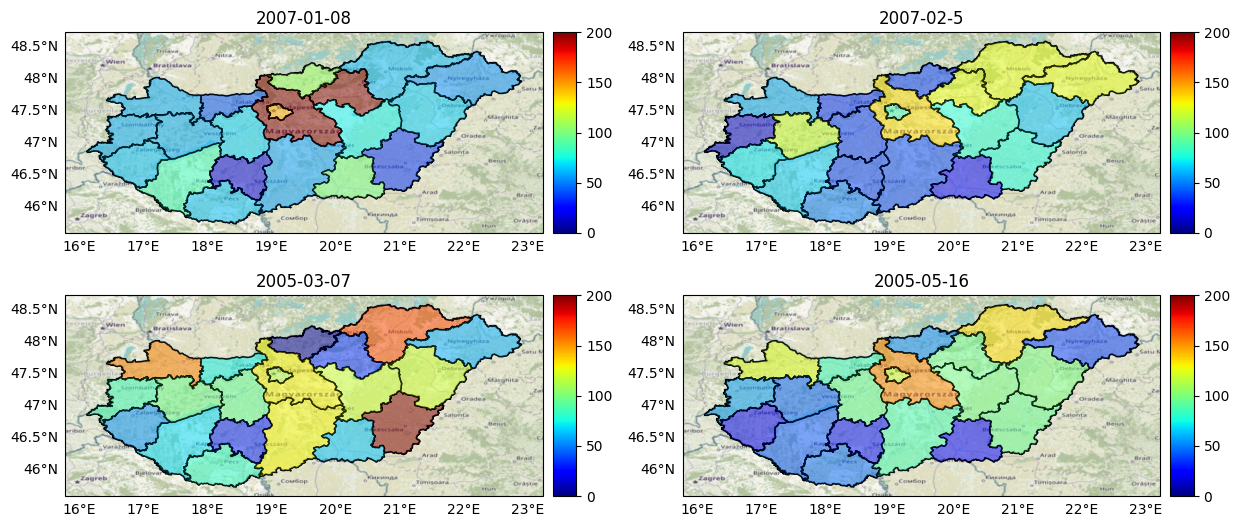

In [ ]:
# Create a dataframe for plotting using geopandas.
hungary = gpd.read_file('HUN_ADM1.shp')
df_plot = df_train.copy()
df_plot['centroid'] = df_plot[['longitude','latitude']].apply(Point, axis=1)
centroid_to_polygon = {
    c: next(g for g in hungary.geometry.values if g.contains(c))
    for c in set(df_plot['centroid'])
    }
df_plot['boundary'] = df_plot['centroid'].replace(centroid_to_polygon)

# Helper function to plot a single map.
def plot_map(date, ax):
  # Plot basemap.
  hungary.plot(color='none', edgecolor='black', linewidth=1, ax=ax)
  ctx.add_basemap(ax, crs=hungary.crs.to_string(), attribution='', zorder=-1)
  # Make legend axes.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad='2%', axes_class=plt.matplotlib.axes.Axes)
  # Set date
  # Plot stations.
  df_plot_geo = gpd.GeoDataFrame(df_plot, geometry='boundary')
  df_plot_geo_t0 = df_plot_geo[df_plot_geo.datetime==date]
  df_plot_geo_t0.plot(
      column='chickenpox', alpha=.5, vmin=0, vmax=200, edgecolor='k',
      linewidth=1, legend=True, cmap='jet', cax=cax, ax=ax)
  gl = ax.gridlines(draw_labels=True, alpha=0)
  gl.top_labels = False
  gl.right_labels = False
  ax.set_title(date)

fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(12.5, 12.5), tight_layout=True)

dates = ['2007-01-08', '2007-02-5', '2005-03-07', '2005-05-16']
for ax, date in zip(axes.flat, dates):
  plot_map(date, ax)


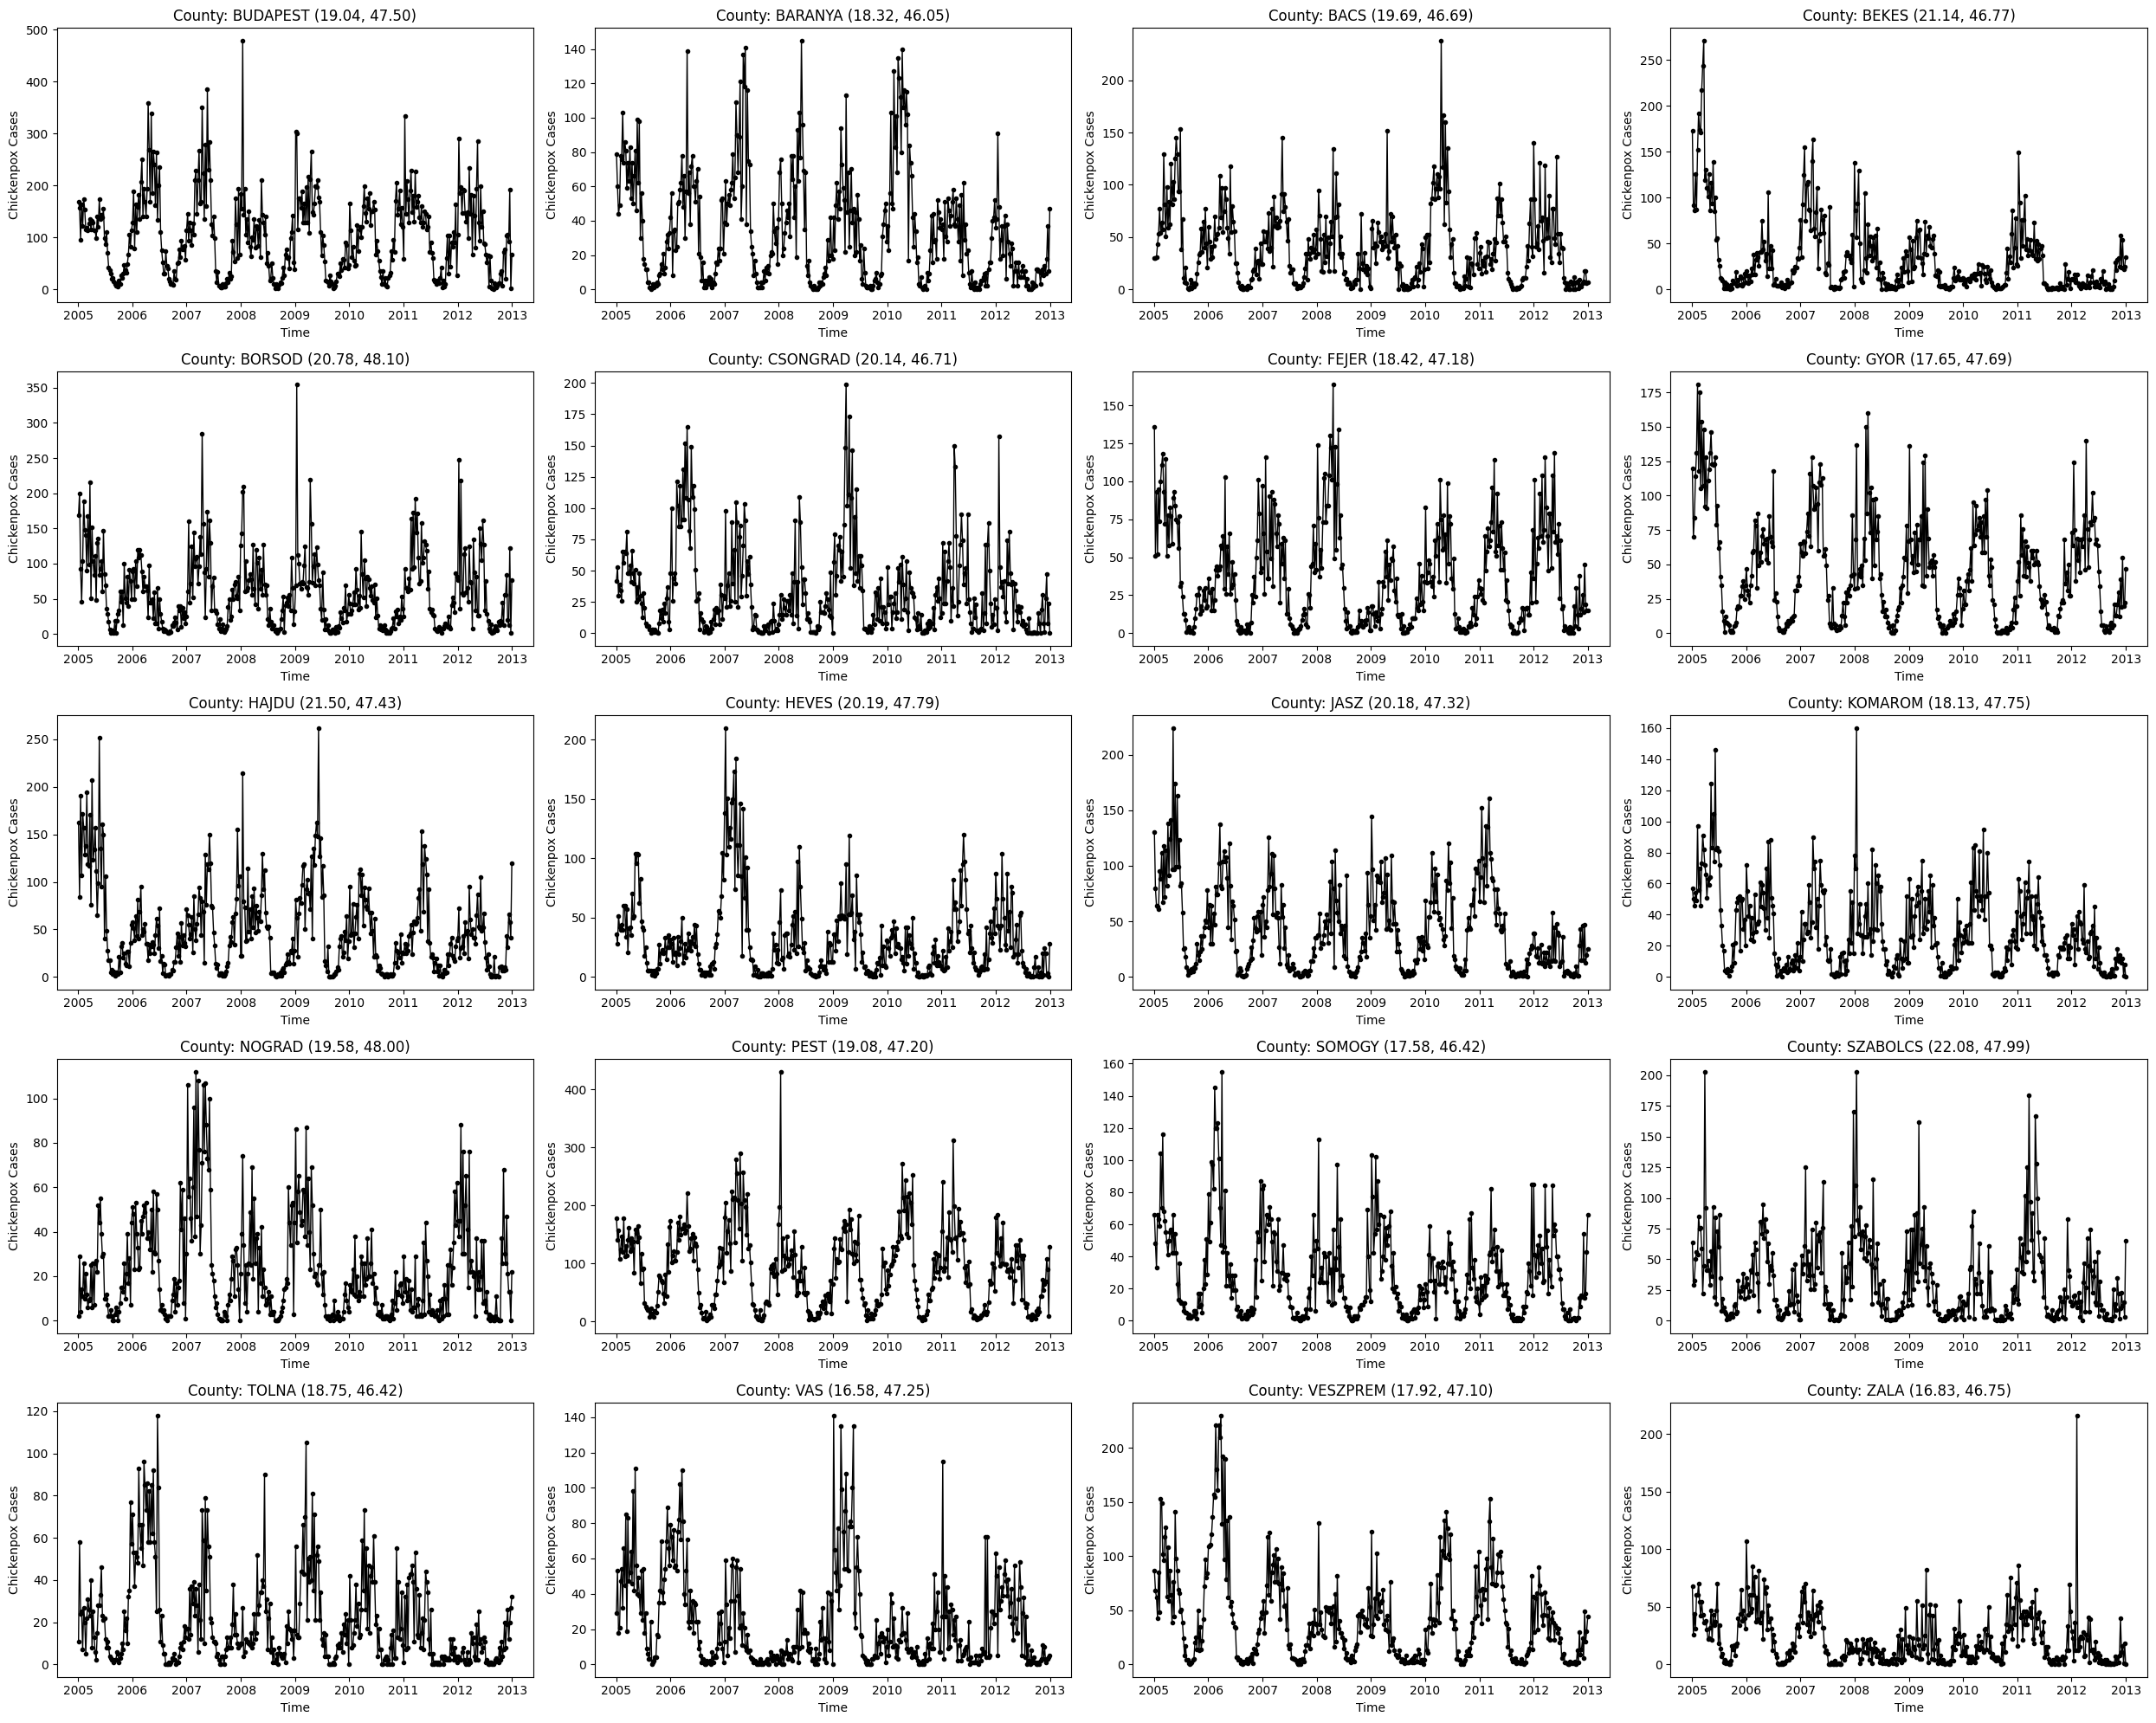

In [ ]:
locations = df_train.location.unique()
fig, axes = plt.subplots(ncols=4, nrows=5, tight_layout=True, figsize=(25,20))
for ax, location in zip(axes.flat, locations):
  df_location = df_train[df_train.location==location]
  latitude, longitude = df_location.iloc[0][['latitude', 'longitude']]
  ax.plot(df_location.datetime, df_location.chickenpox, marker='.', color='k', linewidth=1)
  ax.set_title(f'County: {location} ({longitude:.2f}, {latitude:.2f})')
  ax.set_xlabel('Time')
  ax.set_ylabel('Chickenpox Cases')

In [ ]:
model = BayesianNeuralFieldMAP(
  width=256,
  depth=6,
  freq='W',
  seasonality_periods=['M', 'Y'], # equivalent to [365.25/12, 365.25]
  num_seasonal_harmonics=[2, 10], # two harmonics for M; one harmonic for Y
  feature_cols=['datetime', 'latitude', 'longitude'], # time, spatial 1, ..., spatial n
  target_col='chickenpox',
  observation_model='NB',
  timetype='index',
  #standardize=['latitude', 'longitude'],
  interactions=[(0, 1), (0, 2), (1, 2)]
  )
model = model.to(device)

In [ ]:
model = model.fit(
    df_train,
    seed=torch.manual_seed(0),
    ensemble_size=8,
    num_epochs=150,
    )

Epoch [1/150], Loss: 3877.0897521972656
Epoch [2/150], Loss: 27739.805419921875
Epoch [3/150], Loss: 2655.7649841308594
Epoch [4/150], Loss: 16132.427062988281
Epoch [5/150], Loss: 3987.171142578125
Epoch [6/150], Loss: 15078.295318603516
Epoch [7/150], Loss: 3728.4366760253906
Epoch [8/150], Loss: 14629.094818115234
Epoch [9/150], Loss: 3496.2809143066406
Epoch [10/150], Loss: 14299.512145996094
Epoch [11/150], Loss: 3360.5562438964844
Epoch [12/150], Loss: 13847.068969726562
Epoch [13/150], Loss: 3226.8834838867188
Epoch [14/150], Loss: 13336.383972167969
Epoch [15/150], Loss: 3168.621124267578
Epoch [16/150], Loss: 13024.254089355469
Epoch [17/150], Loss: 3094.8009033203125
Epoch [18/150], Loss: 12620.33773803711
Epoch [19/150], Loss: 3019.959716796875
Epoch [20/150], Loss: 12396.174072265625
Epoch [21/150], Loss: 2950.2813415527344
Epoch [22/150], Loss: 12245.292053222656
Epoch [23/150], Loss: 2909.540008544922
Epoch [24/150], Loss: 11933.311401367188
Epoch [25/150], Loss: 2871.581

In [ ]:
yhat, yhat_quantiles = model.predict(df_test, quantiles=(0.025, 0.5, 0.975))

In [ ]:
rmse = np.sqrt(np.mean((df_test['chickenpox'] - yhat) ** 2))
print(f"RMSE: {rmse}")

RMSE: 35.50316541406665
